<a href="https://colab.research.google.com/github/ll-cooool-j/DS-Assignment/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install pycountry_convert 
!pip install folium
!pip install calmap
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
!pip install openpyxl
!pip install scikit-learn
!pip install fsspec
!pip install pystan

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px
import pycountry_convert as pc
import folium
import branca
import plotly.express as px
import json, requests
import calmap
import warnings
import covsirphy as cs
import sympy as sym
import functools
import math
import os
import matplotlib.cm as cm
import scipy as sci
import dask.dataframe as dd

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.ticker import ScalarFormatter
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from matplotlib import ticker 
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display, Markdown
from pprint import pprint
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

In [4]:
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.plotting.register_matplotlib_converters()
pd.set_option("display.max_colwidth", 1000)

# Import CSV

In [21]:
glo_bal = pd.read_csv('/content/Global.csv')
glo_bal.head(2)

,Date,Confirmed,Deaths,Recovered,Infected
0,01-Jul-20,10675596,541738,5468425,4665433
1,02-Jul-20,10885548,547161,5753359,4585028


In [7]:
glo_bal["Infected"] = glo_bal["Confirmed"]-glo_bal["Recovered"]-glo_bal["Deaths"]
glo_bal.head()

,Date,Confirmed,Deaths,Recovered,Infected
0,01-Jul-20,10675596,541738,5468425,4665433
1,02-Jul-20,10885548,547161,5753359,4585028
2,03-Jul-20,11086923,552455,5863247,4671221
3,04-Jul-20,11280744,557248,6059007,4664489
4,05-Jul-20,11464726,561077,6178370,4725279


# Train-test split

In [25]:
X = glo_bal.iloc[:,1:4]
X.head()

,Confirmed,Deaths,Recovered
0,10675596,541738,5468425
1,10885548,547161,5753359
2,11086923,552455,5863247
3,11280744,557248,6059007
4,11464726,561077,6178370


In [9]:
y = glo_bal[['Infected']]
y.head()

,Infected
0,4665433
1,4585028
2,4671221
3,4664489
4,4725279


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# MODEL

***Linear Regression model***

In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

***Logistic Regression model***

In [12]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(random_state =42)
logistic_classifier.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [13]:
logistic_classifier.score(X_test,y_test)

0.0

***SVC model***

In [14]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 42)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [15]:
classifier.score(X_test,y_test)

0.0

***SIR model***

In [16]:
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [17]:
print(cs.SIR.NAME)
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


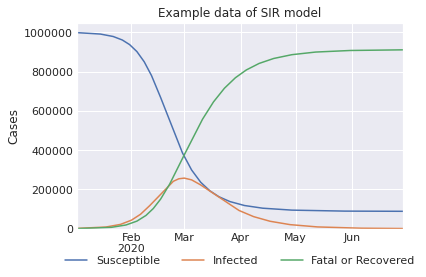

In [18]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

In [19]:
from scipy.integrate import odeint

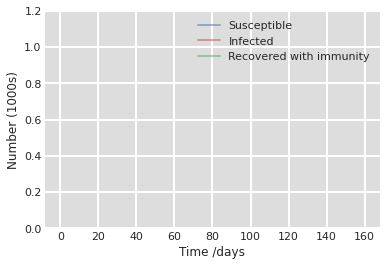

In [32]:
# Total population, N.
N = 126476458
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1299, 17539
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

***ARIMA model***

        Date  Confirmed  Deaths  Recovered  Infected
0  01-Jul-20   10675596  541738    5468425   4665433
1  02-Jul-20   10885548  547161    5753359   4585028
2  03-Jul-20   11086923  552455    5863247   4671221
3  04-Jul-20   11280744  557248    6059007   4664489
4  05-Jul-20   11464726  561077    6178370   4725279


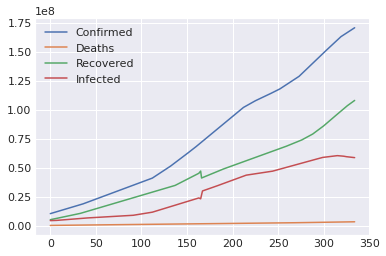

In [ ]:
print(glo_bal.head())
glo_bal.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

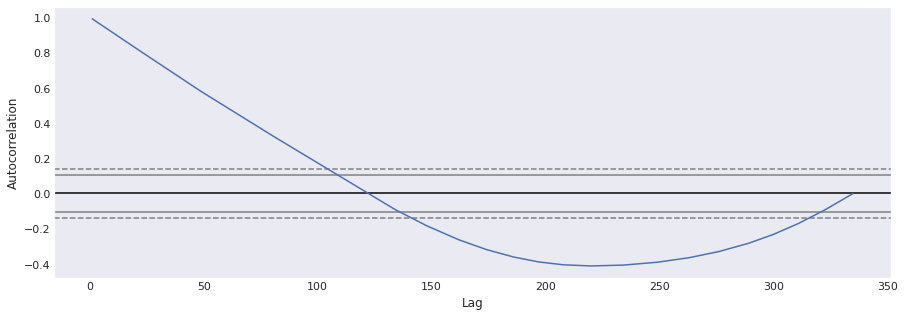

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(glo_bal['Confirmed'], ax=ax)
plt.show()

<Figure size 432x288 with 0 Axes>

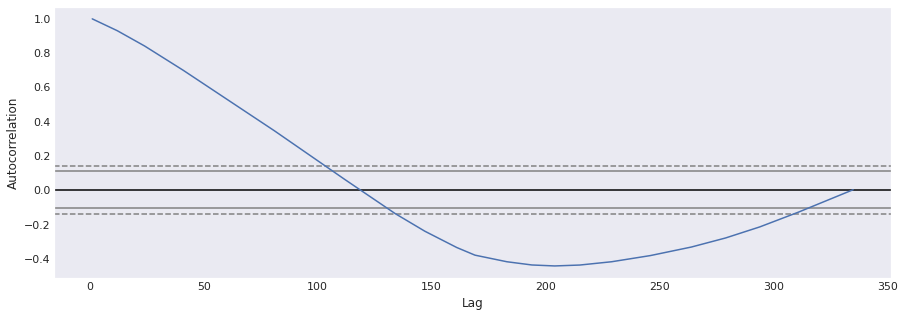

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(glo_bal['Infected'], ax=ax)
plt.show()

In [ ]:
model1 = ARIMA(glo_bal, order=(5,1,0))


ValueError: ignored

***Random Forest model***

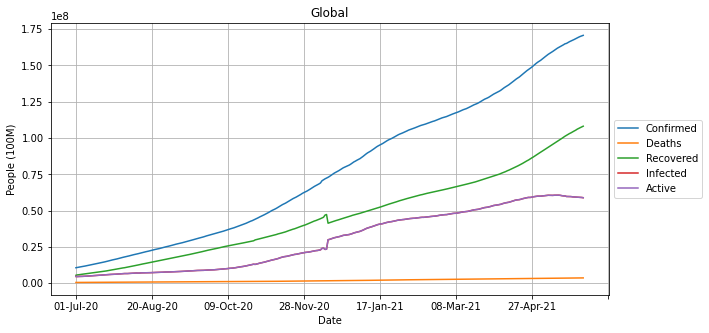

0.9993272249238169


In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px # install plotly
from datetime import datetime
%matplotlib inline
from sklearn.metrics import r2_score

glo_bal = pd.read_csv('/content/Global.csv')
glo_bal['Active'] = glo_bal['Confirmed'] - glo_bal['Deaths'] - glo_bal['Recovered']
glo_bal.plot( xlabel = 'Date', ylabel = 'People (100M)', x = 'Date', title = 'Global', grid = True, figsize = (10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
X = glo_bal.iloc[:, 1:4]
y = glo_bal.iloc[:, 4:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train, y_train.values.ravel())
y_predict = regressor.predict(X_test)
prediction = regressor.predict(X)
print(r2_score(y_test, y_predict))
